In [92]:

from fastai.torch_basics import *
from fastai.data.all import *
from fastai.tabular.data import *
from fastai.tabular.core import *
from fastai.tabular.model import *
from fastai.basics import *
from fastrenewables.tabular.core import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.model import *
from fastrenewables.utils import *
from fastrenewables.gan.learner import *

from fastrenewables.timeseries.core import *
from fastrenewables.timeseries.data import *
from fastrenewables.timeseries.model import *

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_dls(cat_names, cont_names):
    pd.options.mode.chained_assignment=None
    
    dls = RenewableDataLoaders.from_files(glob.glob("../data/*.h5"), 
                                          pre_procs=[FilterYear(year=2020)],
                                          procs = [NormalizePerTask(norm_type="minmaxnorm")],
                                          cat_names=cat_names, cont_names=cont_names, y_names=cont_names)
    return dls



In [3]:
cont_names = ['WindSpeed58m', 'PS_SFC_0_M',  "PowerGeneration"]
cat_names = ['TaskID']

In [4]:
dls = get_dls(cat_names, cont_names)

In [5]:
n_cats = len(dls.train_ds.cats.TaskID.unique()) #len(cat_names)
n_conts =  len(cont_names)

In [100]:
emb_module = EmbeddingModule(categorical_dimensions=[n_cats+1])
# emb_module = None
emb_module

EmbeddingModule(
  (embeddings): ModuleList(
    (0): Embedding(4, 3)
  )
)

In [101]:
n_samples = 1024
n_classes = 2 # TODO is this n_cats for auxilary?
n_features = n_conts
# batch_size = 512
n_z = 10
n_in = n_features
n_hidden = 256
epochs = 50
n_gen = 1
n_dis = 1
batch_norm = True

In [104]:
structure = [n_z, n_hidden, n_hidden, n_hidden, n_in]

In [102]:
model = get_gan_model(structure=structure, 
                      n_classes=n_classes, 
                      emb_module=emb_module, 
                      bn=batch_norm, 
                      gan_type='bce')

In [103]:
model

GAN(
  (generator): GANMLP(
    (embedding_module): EmbeddingModule(
      (embeddings): ModuleList(
        (0): Embedding(4, 3)
      )
    )
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=13, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Linear(in_features=256, out_features=3, bias=True)
      )
      (4): Sigmoid()
    )
  )
  (discriminator): GANMLP(
    (embedding_module): EmbeddingModule(
     

In [9]:
lr = 1e-4
learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)
learner.fit(dls.train, epochs=epochs, lr=lr, plot_epochs=epochs, save_model=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:23<00:00,  4.07s/it]


In [18]:
all_fakes_conts, all_cats = [], []

In [19]:
for x_cat, x_cont, y in dls.valid:
    x_fake = learner.generate_samples(x_cat, x_cont)
    all_fakes_conts.append(x_fake)
    all_cats.append(x_cat)

In [21]:
all_fakes_conts = torch.cat(all_fakes_conts)
all_cats = torch.cat(all_cats)

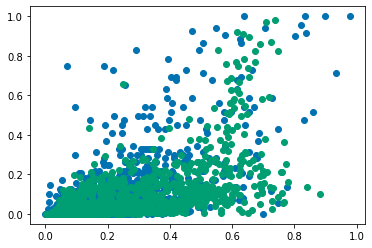

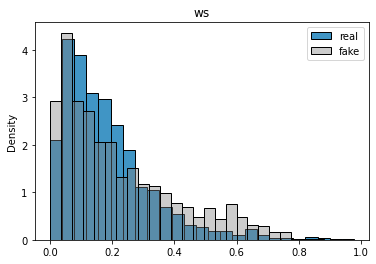

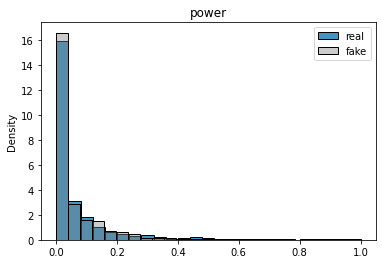

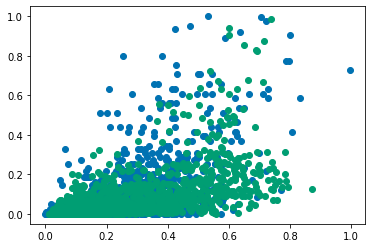

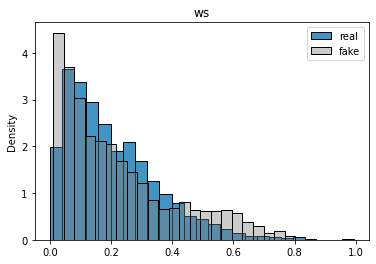

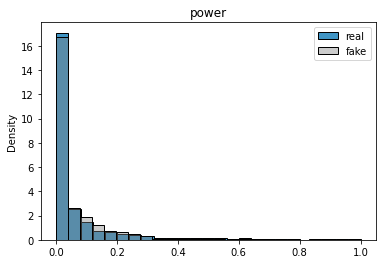

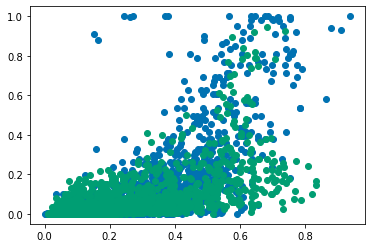

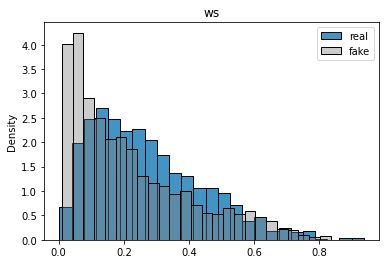

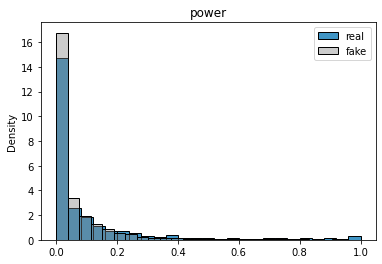

In [91]:
for tid in all_cats.unique():
    mask = (dls.valid_ds.cats == float(tid)).values
    ws = dls.valid_ds.conts.WindSpeed58m.values[mask.reshape(-1)]
    power = dls.valid_ds.conts.PowerGeneration.values[mask.reshape(-1)]
    plt.scatter(ws, power)
    mask = all_cats == float(tid)
    
    ws_fake = all_fakes_conts[mask.reshape(-1),0]
    power_fake = all_fakes_conts[mask.reshape(-1),-1]
    plt.scatter(ws_fake,power_fake)
    plt.show()
    
    n_bins = 25
    stat_type = "probability"
    stat_type = "density"
    sns.histplot(ws, label="real", stat=stat_type, bins=n_bins)
    sns.histplot(ws_fake, label="fake", alpha=0.4, color="grey", stat=stat_type, bins=n_bins)
    plt.title("ws")
    plt.legend()
    plt.show()
    
    sns.histplot(power, label="real", stat=stat_type, bins=n_bins)
    sns.histplot(power_fake, label="fake", alpha=0.4, color="grey", stat=stat_type, bins=n_bins)
    plt.title("power")
    plt.legend()
    plt.show()

In [14]:
model

GAN(
  (generator): GANMLP(
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=10, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Linear(in_features=256, out_features=3, bias=True)
      )
      (4): Sigmoid()
    )
  )
  (discriminator): GANMLP(
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=3, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      

In [95]:
def get_dls_ts(cat_names, cont_names):
    pd.options.mode.chained_assignment=None
    
    dls = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5"), 
                                          pre_procs=[FilterYear(year=2020), FilterInconsistentSamplesPerDay],
                                          procs = [NormalizePerTask(norm_type="minmaxnorm")],
                                          cat_names=cat_names, cont_names=cont_names, y_names=cont_names)
    return dls



In [96]:
dls_ts = get_dls_ts(cat_names, cont_names)

In [98]:
emb_module = EmbeddingModule(categorical_dimensions=[n_cats+1])
# emb_module = None
emb_module

In [222]:
n_hidden = 64
n_z = 128
structure = [n_z, 128, 64, 32, n_in]

In [223]:
generator = TemporalCNN(cnn_structure=structure, batch_norm_cont=False, 
                                   cnn_type='tcn', 
                                   final_activation=nn.Sigmoid,
                                   embedding_module=emb_module, 
                                   add_embedding_at_layer=[idx for idx in range(len(structure)-2)],
                       )
generator

TemporalCNN(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(4, 3)
    )
  )
  (layers): TemporalConvNet(
    (temporal_blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (act_func1): ReLU()
        (dropout1): Dropout2d(p=0.0, inplace=False)
        (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (act_func2): ReLU()
        (dropout2): Dropout2d(p=0.0, inplace=False)
        (net): Sequential(
          (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout2d(p=0.0, inplace=False)
          (4): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout2d(p=0.0, inplace=False)
        )
        (act_func3): ReLU()
        (e

In [224]:
dis_structure = structure[::-1]
dis_structure[-1] = 1
discriminator = TemporalCNN(cnn_structure=dis_structure, batch_norm_cont=False, 
                                   cnn_type='tcn', 
                                   final_activation=nn.Sigmoid,
                                   embedding_module=emb_module, 
                                   add_embedding_at_layer=[idx for idx in range(len(dis_structure)-2)],
                       )
discriminator

TemporalCNN(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(4, 3)
    )
  )
  (layers): TemporalConvNet(
    (temporal_blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (act_func1): ReLU()
        (dropout1): Dropout2d(p=0.0, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (act_func2): ReLU()
        (dropout2): Dropout2d(p=0.0, inplace=False)
        (net): Sequential(
          (0): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout2d(p=0.0, inplace=False)
          (4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout2d(p=0.0, inplace=False)
        )
        (downsample): Conv1d(3, 32, kernel_size=

In [225]:
gan_class = GAN
opt_fct = torch.optim.Adam
auxiliary=False
aux_factor=0.0
label_noise=0
label_bias=0

gen_opt = opt_fct(params=generator.parameters())
dis_opt = opt_fct(params=discriminator.parameters())
model = gan_class(generator=generator, discriminator=discriminator, gen_optim=gen_opt, dis_optim=dis_opt, n_z=n_z, \
                  auxiliary=auxiliary, auxiliary_weighting_factor=aux_factor, \
                  label_noise=label_noise, label_bias=label_bias)

In [ ]:
lr = 1e-4
epochs = 50
learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)
learner.fit(dls_ts.train, epochs=epochs, lr=lr, plot_epochs=epochs, save_model=True)

  4%|█████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                       | 2/50 [00:03<01:12,  1.51s/it]

In [ ]:
all_fakes_conts, all_cats = [], []
for x_cat, x_cont, y in dls_ts.valid:
    x_fake = learner.generate_samples(x_cat, x_cont)
    all_fakes_conts.append(x_fake)
    all_cats.append(x_cat)
    
all_fakes_conts = torch.cat(all_fakes_conts)
all_cats = torch.cat(all_cats)

In [ ]:
all_fakes_conts.shape, all_cats.shape

In [ ]:
for tid in all_cats.unique():
    mask = (dls.valid_ds.cats == float(tid)).values
    ws = dls.valid_ds.conts.WindSpeed58m.values[mask.reshape(-1)]
    power = dls.valid_ds.conts.PowerGeneration.values[mask.reshape(-1)]
    plt.scatter(ws, power)
    
    
    mask = flatten_ts(all_cats) == float(tid)
    ws_fake = flatten_ts(all_fakes_conts)[mask.reshape(-1),0]
    power_fake = flatten_ts(all_fakes_conts)[mask.reshape(-1),-1]
    plt.scatter(ws_fake,power_fake)
    plt.show()
    
    n_bins = 25
    stat_type = "probability"
    stat_type = "density"
    sns.histplot(ws, label="real", stat=stat_type, bins=n_bins)
    sns.histplot(ws_fake, label="fake", alpha=0.4, color="grey", stat=stat_type, bins=n_bins)
    plt.title("ws")
    plt.legend()
    plt.show()
    
    sns.histplot(power, label="real", stat=stat_type, bins=n_bins)
    sns.histplot(power_fake, label="fake", alpha=0.4, color="grey", stat=stat_type, bins=n_bins)
    plt.title("power")
    plt.legend()
    plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
plot_acf(dls.valid_ds.conts.sort_index().PowerGeneration, lags=24)
plt.show()

In [ ]:
plot_acf(dls.valid_ds.conts.sort_index().WindSpeed58m, lags=24)
plt.show()

In [ ]:
plot_acf(all_fakes_conts[:,0,:].reshape(-1), lags=24)
plt.show()

In [ ]:
plot_acf(all_fakes_conts[:,2,:].reshape(-1), lags=24)
plt.show()